In [3]:
# Imports & Settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

plt.rcParams["figure.figsize"] = (18, 8)


In [8]:
DATA_PATH = r"C:\Users\SUNYLoaner\Desktop\Code\ML Projects\SPS\NSE\NSE-DATA.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (1235, 8)


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [9]:
# --- make column names easier to handle ---
df.columns = [c.strip() for c in df.columns]

# Required base columns
required = ["Date", "Open", "High", "Low", "Close"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# Volume column name can vary
if "Total Trade Quantity" in df.columns:
    df = df.rename(columns={"Total Trade Quantity": "Volume"})
elif "Volume" not in df.columns:
    raise ValueError("Could not find Volume column. Expected 'Total Trade Quantity' or 'Volume'.")

# Date conversion
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Convert numeric columns
for col in ["Open", "High", "Low", "Close", "Volume"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop bad rows
df = df.dropna(subset=["Date", "Open", "High", "Low", "Close", "Volume"])

# Sort by Date
df = df.sort_values("Date").reset_index(drop=True)

# Set Date index (useful for plotting)
df = df.set_index("Date")

print(df[["Open","High","Low","Close","Volume"]].head())


              Open    High     Low   Close     Volume
Date                                                 
2013-10-08  157.00  157.80  155.20  155.80  1720413.0
2013-10-09  155.70  158.20  154.15  155.55  2049580.0
2013-10-10  156.00  160.80  155.85  160.15  3124853.0
2013-10-11  161.15  163.45  159.00  160.05  1880046.0
2013-10-14  160.85  161.45  157.70  159.45  1281419.0


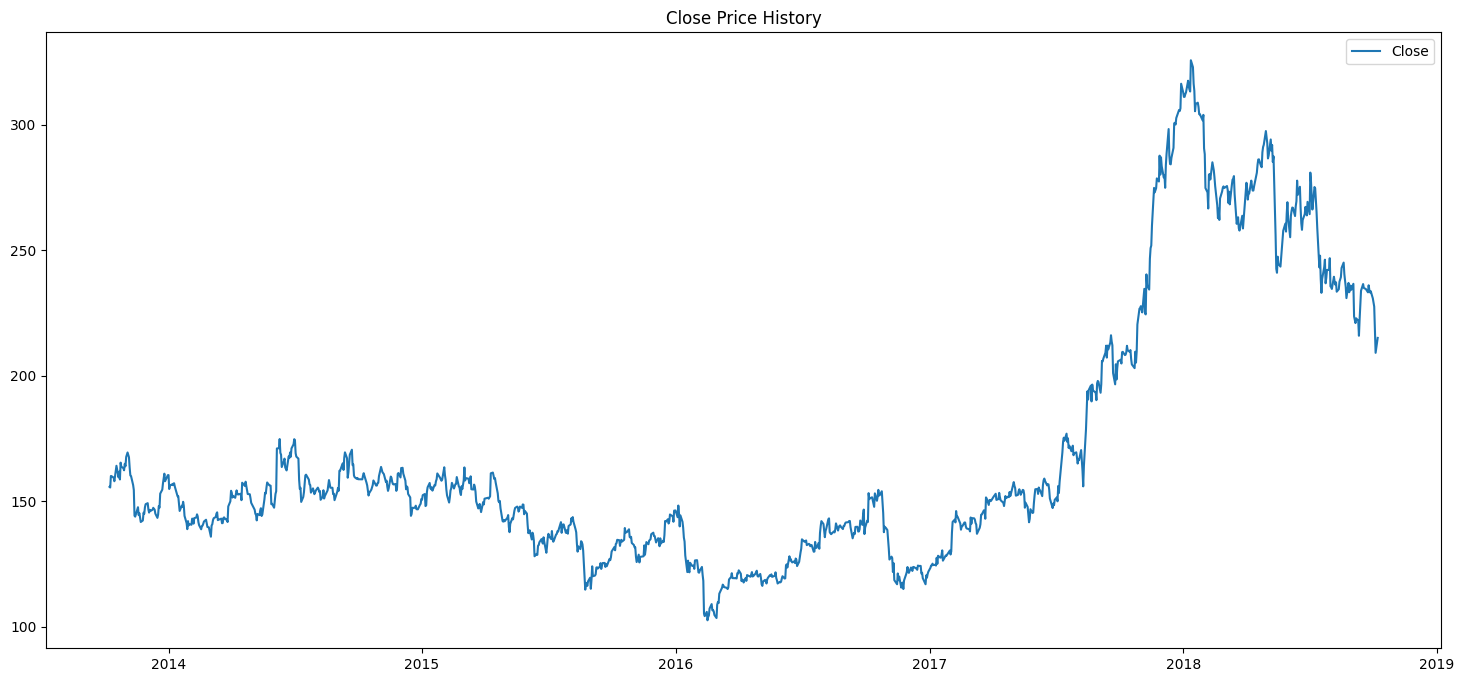

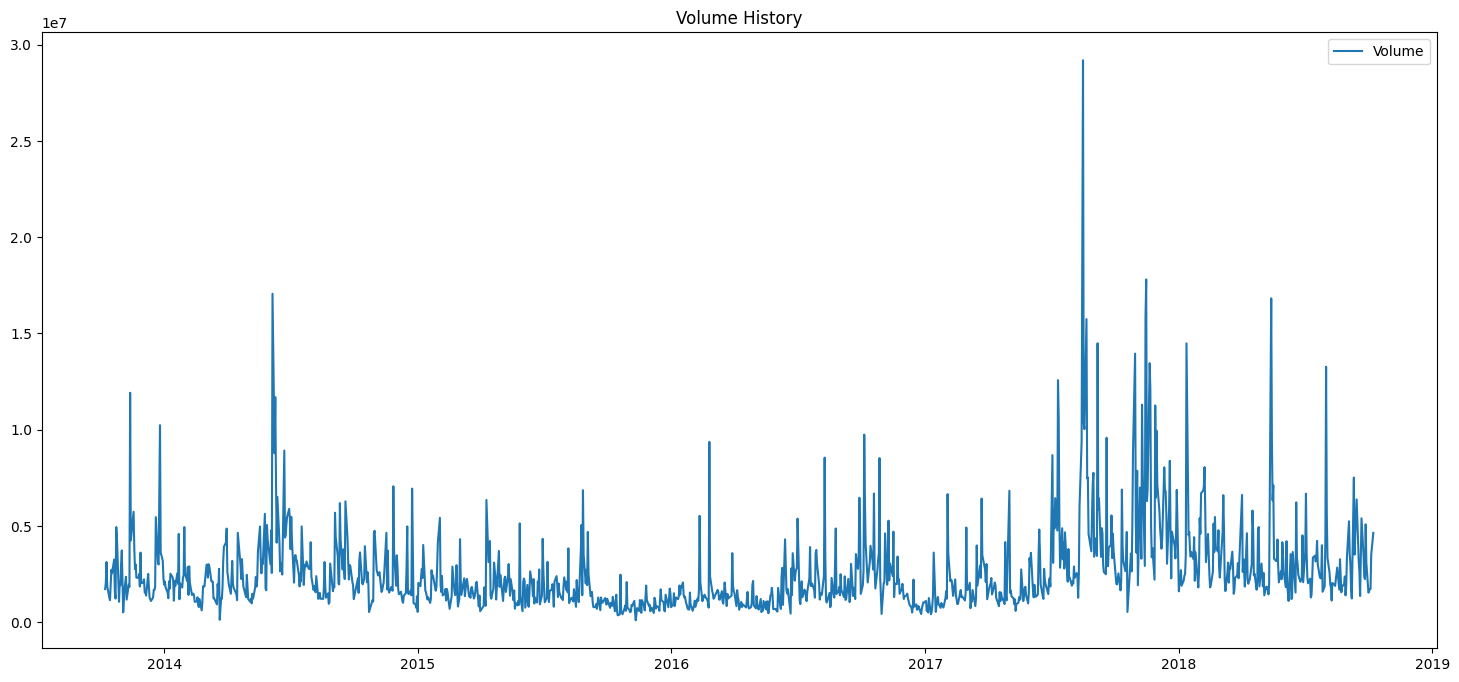

In [10]:
plt.plot(df["Close"], label="Close")
plt.title("Close Price History")
plt.legend()
plt.show()

plt.plot(df["Volume"], label="Volume")
plt.title("Volume History")
plt.legend()
plt.show()


In [11]:
features = ["Open", "High", "Low", "Close", "Volume"]
target = "Close"

data_X = df[features].copy()
data_y = df[[target]].copy()   # keep as 2D for scaler

print("X shape:", data_X.shape)
print("y shape:", data_y.shape)


X shape: (1235, 5)
y shape: (1235, 1)


In [12]:
train_size = 987
lookback = 60

if len(df) <= train_size + lookback:
    raise ValueError("Not enough rows for train_size + lookback. Reduce train_size or lookback.")

X_train_raw = data_X.iloc[:train_size].values
y_train_raw = data_y.iloc[:train_size].values

X_valid_raw = data_X.iloc[train_size:].values
y_valid_raw = data_y.iloc[train_size:].values

print("Train rows:", len(X_train_raw))
print("Valid rows:", len(X_valid_raw))


Train rows: 987
Valid rows: 248


In [13]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)

X_valid_scaled = scaler_X.transform(X_valid_raw)
y_valid_scaled = scaler_y.transform(y_valid_raw)

print("Scaled X_train:", X_train_scaled.shape)
print("Scaled y_train:", y_train_scaled.shape)


Scaled X_train: (987, 5)
Scaled y_train: (987, 1)


In [14]:
def make_sequences(X_scaled, y_scaled, lookback):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X_scaled)):
        X_seq.append(X_scaled[i-lookback:i, :])   # ALL features
        y_seq.append(y_scaled[i, 0])              # next-day Close
    return np.array(X_seq), np.array(y_seq)

# Train sequences
X_train, y_train = make_sequences(X_train_scaled, y_train_scaled, lookback)

# Validation sequences need history from last lookback train rows
X_valid_input = np.vstack([X_train_scaled[-lookback:], X_valid_scaled])
y_valid_input = np.vstack([y_train_scaled[-lookback:], y_valid_scaled])

X_valid, y_valid = make_sequences(X_valid_input, y_valid_input, lookback)

print("X_train shape:", X_train.shape)  # (samples, 60, 5)
print("y_train shape:", y_train.shape)  # (samples,)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)


X_train shape: (927, 60, 5)
y_train shape: (927,)
X_valid shape: (248, 60, 5)
y_valid shape: (248,)


In [15]:
n_features = X_train.shape[2]

model_v2 = Sequential()
model_v2.add(Input(shape=(lookback, n_features)))

model_v2.add(LSTM(64, return_sequences=True))
model_v2.add(Dropout(0.2))

model_v2.add(LSTM(64))
model_v2.add(Dropout(0.2))

model_v2.add(Dense(1))

model_v2.compile(loss="mean_squared_error", optimizer="adam")
model_v2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
)

history = model_v2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=32,
    verbose=2,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/200
29/29 - 3s - 115ms/step - loss: 0.0386 - val_loss: 0.1984 - learning_rate: 0.0010
Epoch 2/200
29/29 - 2s - 67ms/step - loss: 0.0058 - val_loss: 0.1075 - learning_rate: 0.0010
Epoch 3/200
29/29 - 2s - 73ms/step - loss: 0.0042 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 4/200
29/29 - 2s - 68ms/step - loss: 0.0039 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 5/200
29/29 - 2s - 63ms/step - loss: 0.0038 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 6/200
29/29 - 2s - 65ms/step - loss: 0.0036 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 7/200
29/29 - 2s - 61ms/step - loss: 0.0035 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 8/200
29/29 - 2s - 76ms/step - loss: 0.0033 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 9/200
29/29 - 2s - 65ms/step - loss: 0.0031 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 10/200
29/29 - 2s - 62ms/step - loss: 0.0028 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 11/200
29/29 - 2s - 63ms/step - loss: 0.0032 - val_loss: 0.009

In [17]:
pred_scaled = model_v2.predict(X_valid, verbose=0)

# Inverse transform using scaler_y (target scaler)
pred_price = scaler_y.inverse_transform(pred_scaled)
actual_price = scaler_y.inverse_transform(y_valid.reshape(-1, 1))

print("Predicted shape:", pred_price.shape)
print("Actual shape:", actual_price.shape)


Predicted shape: (248, 1)
Actual shape: (248, 1)


In [18]:
rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
mae = mean_absolute_error(actual_price, pred_price)

mape = np.mean(np.abs((actual_price - pred_price) / actual_price)) * 100
accuracy_like = 100 - mape

r2 = r2_score(actual_price, pred_price)

print("\nV2 Model Evaluation Metrics")
print("--------------------------")
print(f"RMSE (₹): {rmse:.2f}")
print(f"MAE  (₹): {mae:.2f}")
print(f"MAPE (%): {mape:.2f}")
print(f"Approx Accuracy (%): {accuracy_like:.2f}")
print(f"R² Score: {r2:.3f}")



V2 Model Evaluation Metrics
--------------------------
RMSE (₹): 8.67
MAE  (₹): 6.18
MAPE (%): 2.38
Approx Accuracy (%): 97.62
R² Score: 0.907


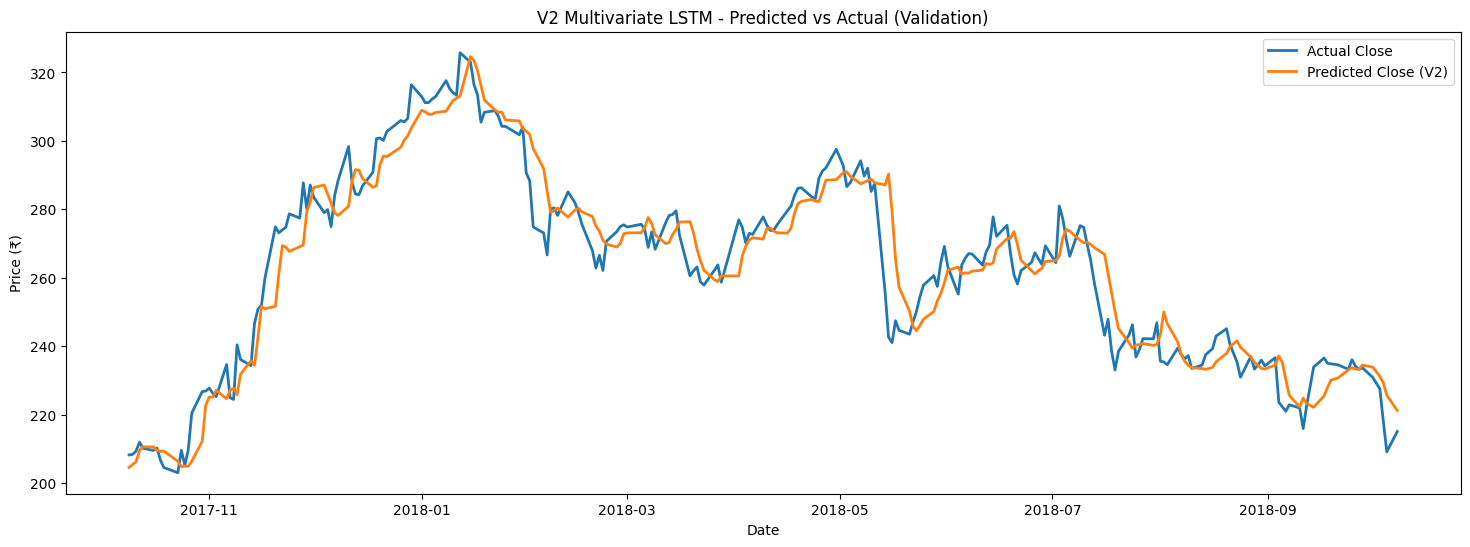

In [19]:
valid_index = df.index[train_size:]  # dates for validation rows

# Our predictions start after lookback offset inside validation window
# X_valid corresponds to y_valid_input[lookback:], which aligns to:
pred_index = valid_index  # because we prepended lookback from train, sequence aligns to validation dates

plt.figure(figsize=(18,6))
plt.plot(pred_index, actual_price, label="Actual Close", linewidth=2)
plt.plot(pred_index, pred_price, label="Predicted Close (V2)", linewidth=2)
plt.title("V2 Multivariate LSTM - Predicted vs Actual (Validation)")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.show()


In [20]:
model_v2.save("saved_lstm_model_v2.keras")
joblib.dump(scaler_X, "scaler_X_v2.pkl")
joblib.dump(scaler_y, "scaler_y_v2.pkl")

print("Saved:")
print(" - saved_lstm_model_v2.keras")
print(" - scaler_X_v2.pkl")
print(" - scaler_y_v2.pkl")


Saved:
 - saved_lstm_model_v2.keras
 - scaler_X_v2.pkl
 - scaler_y_v2.pkl
